In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('wowah_data.csv')

In [3]:
## 전처리

In [4]:
# 컬럼명에 있는 공백 제거
for col in df.columns:
    df = df.rename(columns={col:col.strip()})

In [5]:
# timestamp 컬럼 datetime 유형으로 변경
df['time'] = pd.to_datetime(df['timestamp'])

In [6]:
df = df.rename(columns={'time':'datetime'})

In [7]:
df['year'] = df['datetime'].dt.year  
df['month'] = df['datetime'].dt.month  

In [8]:
df['date'] = df['datetime'].dt.date  
df['time'] = df['datetime'].dt.time  

In [9]:
# 이탈 요인 분석

In [9]:
df = df.sort_values(by=['char', 'datetime']).reset_index()

In [10]:
first_log = df.groupby('char').first()

In [11]:
last_log = df.groupby('char').last()

In [12]:
first_log = first_log[['level', 'race', 'charclass', 'zone', 'guild', 'datetime']].reset_index()
last_log = last_log[['level', 'race', 'charclass', 'zone', 'guild', 'datetime']].reset_index()

In [13]:
first_log = first_log.rename(columns={'datetime':'first_log_time'})
last_log = last_log.rename(columns={'datetime':'last_log_time'})

In [14]:
# 90일 이상 접속하지 않은 유저를 이탈한 유저로 규정
last_log['churn'] = pd.to_datetime('2008-12-31') - last_log.last_log_time > timedelta(days=90)

In [15]:
last_log['churn'] = last_log['churn'].astype('int')

In [16]:
churn_users = last_log[last_log.churn==1].reset_index()

In [18]:
#overall 이탈률
last_log.churn.mean() # 45%의 이탈률

0.45076832467741074

In [197]:
#유저별 첫 접속 및 마지막 접속시간
user_time = pd.merge(first_log, last_log[['char', 'last_log_time']], on='char')

In [208]:
user_time['subscription'] = user_time['last_log_time'] - user_time['first_log_time']

In [209]:
user_time.subscription.mean() #보통 유저들은 72일 정도 계정을 유지

Timedelta('72 days 14:25:04.162472562')

In [210]:
user_time['subscription(days)'] = [dt.days for dt in user_time['subscription'] ]

In [212]:
fig = px.histogram(user_time, x="subscription(days)", nbins=20, template='plotly_dark', text_auto=True, width=800, height=500)
fig.show()
fig.write_image("img/subscription.png")

TypeError: histogram() got an unexpected keyword argument 'text_auto'

In [22]:
churn_users['date'] = churn_users['last_log_time'].dt.date  

In [23]:
#일별 이탈 유저 수
daily_churn = churn_users.groupby('date').churn.sum().reset_index()

In [24]:
#dau
dau = pd.DataFrame(df.groupby('date').char.nunique()).reset_index()

In [25]:
daily_chrun_dau = pd.merge(dau, daily_churn, on='date', how='left')

In [26]:
daily_chrun_dau['churn_rate'] = daily_chrun_dau.churn / daily_chrun_dau.char

In [27]:
daily_chrun_dau = daily_chrun_dau[~daily_chrun_dau.churn_rate.isna()]

In [28]:
del daily_chrun_dau['char']

In [29]:
daily_chrun_dau['churn_rate'].describe()

count    261.000000
mean       0.031959
std        0.009071
min        0.015262
25%        0.025926
50%        0.030405
75%        0.037237
max        0.076804
Name: churn_rate, dtype: float64

In [30]:
daily_chrun_dau['churn_rate_re'] = [round(x, 3) for x in daily_chrun_dau['churn_rate']]

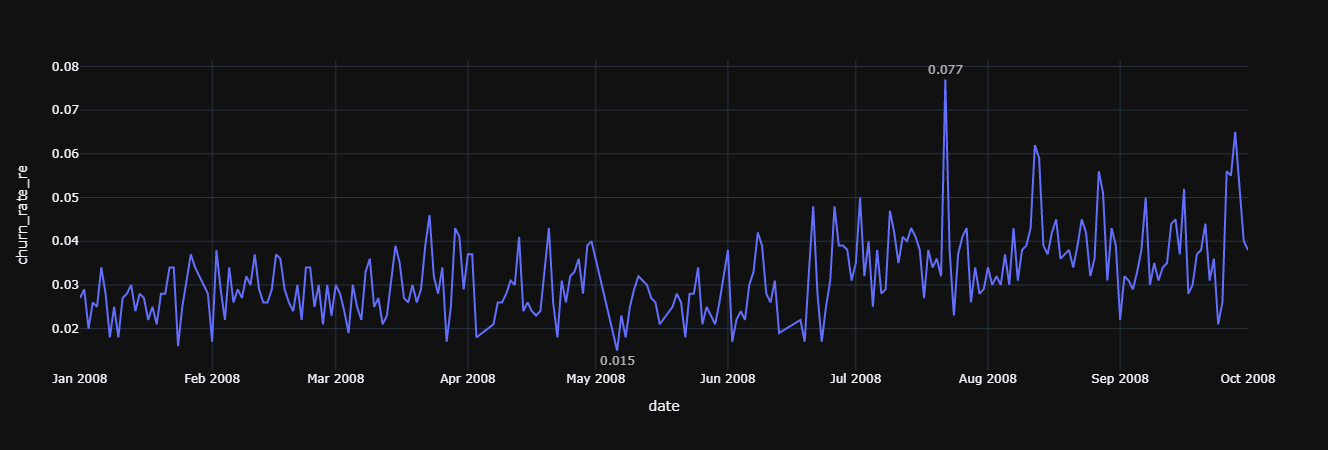

<Figure size 720x288 with 0 Axes>

In [31]:
plt.figure(figsize = (10,4))

import plotly.express as px

fig = px.line(daily_chrun_dau, x="date", y="churn_rate_re", template='plotly_dark')
fig.add_annotation(showarrow=False,
                   align = 'right',
                   x=daily_chrun_dau.date[daily_chrun_dau.max(axis = 1).idxmax()],
                   y=daily_chrun_dau.max().churn_rate_re,
                   text=str(daily_chrun_dau.max().churn_rate_re),
                   yshift=10,
                   opacity=0.7)
fig.add_annotation(showarrow=False,
                   align = 'right',
                   x=daily_chrun_dau.date[daily_chrun_dau.min(axis = 1).idxmin()],
                   y=daily_chrun_dau.min().churn_rate_re,
                   text=str(daily_chrun_dau.min().churn_rate_re),
                   yshift=-10,
                   opacity=0.7)
fig.show()
fig.write_image("img/churn_rate.png")

* 2008년 1월에 이탈률이 크게 증가함. 다르게 말하면 2008년 1월 초에 진입한 유저들은 게임을 계속하고 있음. 원인 파악 필요.

<AxesSubplot:xlabel='level', ylabel='char'>

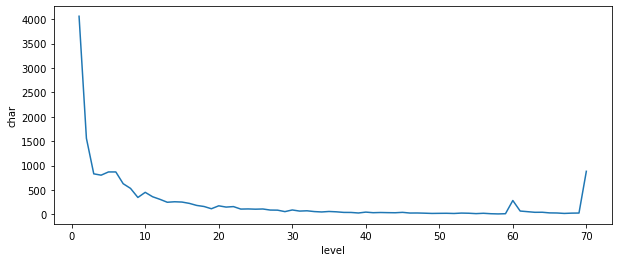

In [32]:
#레벨별 이탈율
churn_level = churn_users.groupby('level').char.count().reset_index()

plt.figure(figsize = (10,4))
sns.lineplot(x='level', y='char', data=churn_level, sort=0)

* 레벨 10 이하에서 많이 떠나므로 레벨 10까지 도달하게 만드는 것이 중요
* 레벨 60에서도 다소 떠난 유저가 많아 게임을 지속할 새로운 요인을 제공할 필요가 있음.
* 최고 레벨인 70 이후에 떠나는 유저들은 더이상 할 것이 없어서 떠나는 것으로 보임.

In [33]:
churn_zone = last_log.groupby('zone').agg({'char':'count', 'churn':'sum'}).reset_index()
churn_zone['churn_rate'] = churn_zone['churn'] / churn_zone['char']
churn_zone_top10 = churn_zone.sort_values(by='churn_rate', ascending=False)
churn_zone_top10 = churn_zone_top10[:10].sort_values(by='churn_rate', ascending=True)

In [34]:
churn_zone_top10['churn_rate'] = [round(x, 2) for x in churn_zone_top10['churn_rate']]

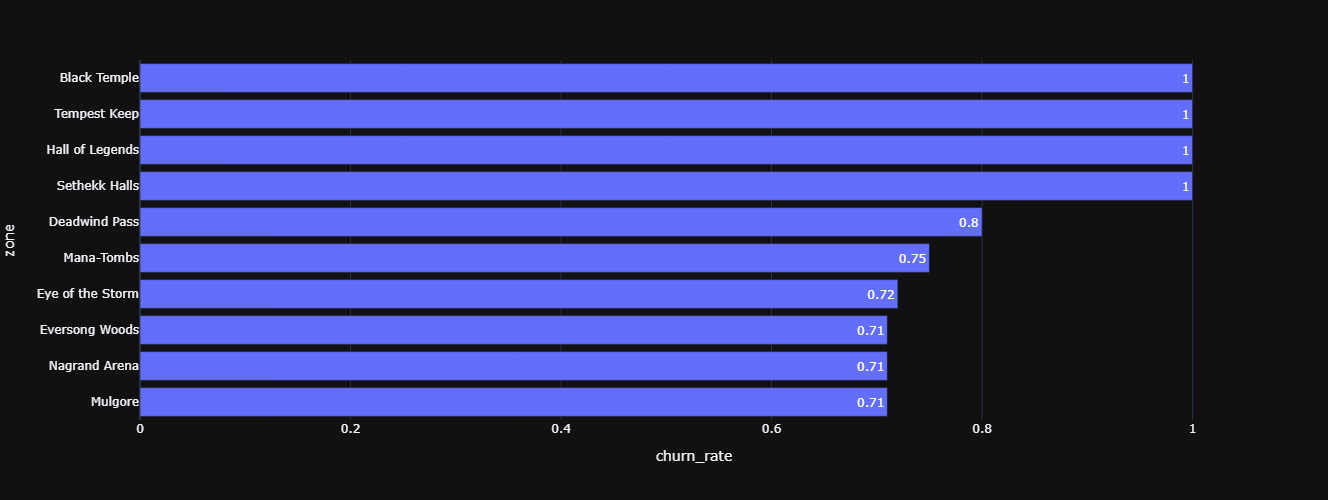

In [35]:
fig = px.bar(churn_zone_top10,  x='churn_rate', y='zone', text='churn_rate', width=800, height=500, template='plotly_dark')
fig.update_traces(textfont_size=12, textangle=0)
fig.show()

fig.write_image("img/zone_churn.png")

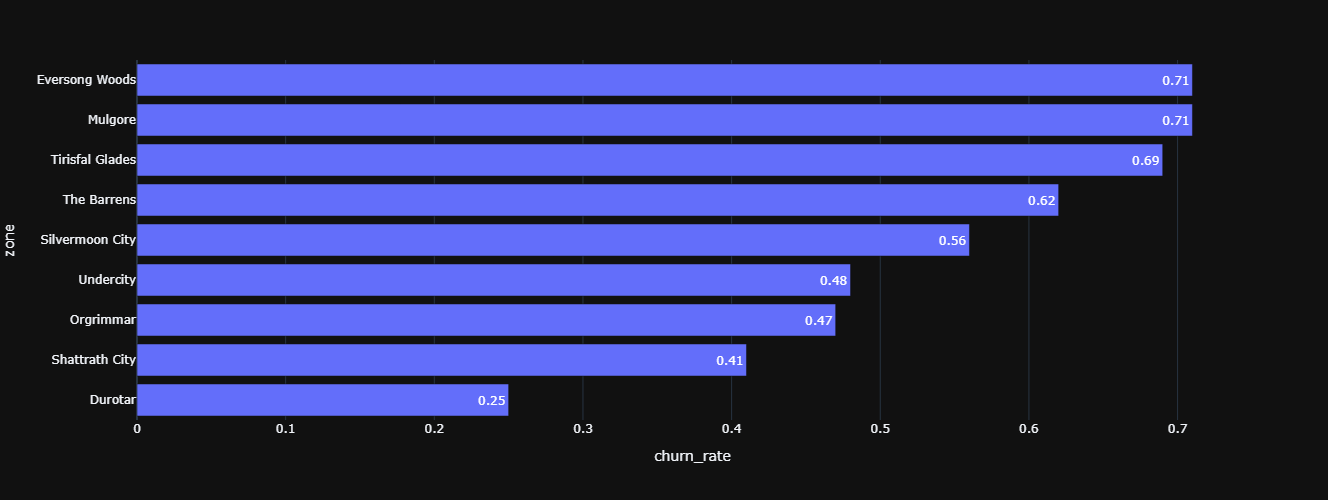

In [36]:
# 1000명 이상 유저 중 이탈률 높은 존들

churn_zone_large = churn_zone[churn_zone.char>1000]
churn_zone_large_top10 = churn_zone_large.sort_values(by='churn_rate', ascending=False)
churn_zone_large_top10 = churn_zone_large_top10[:10].sort_values(by='churn_rate', ascending=True)
churn_zone_large_top10['churn_rate'] = [round(x, 2) for x in churn_zone_large_top10['churn_rate']]

fig = px.bar(churn_zone_large_top10, x='churn_rate', y='zone', text='churn_rate', width=800, height=500, template='plotly_dark')
fig.update_traces(textfont_size=12, textangle=0)
fig.show()

fig.write_image("img/zone_churn_large.png")

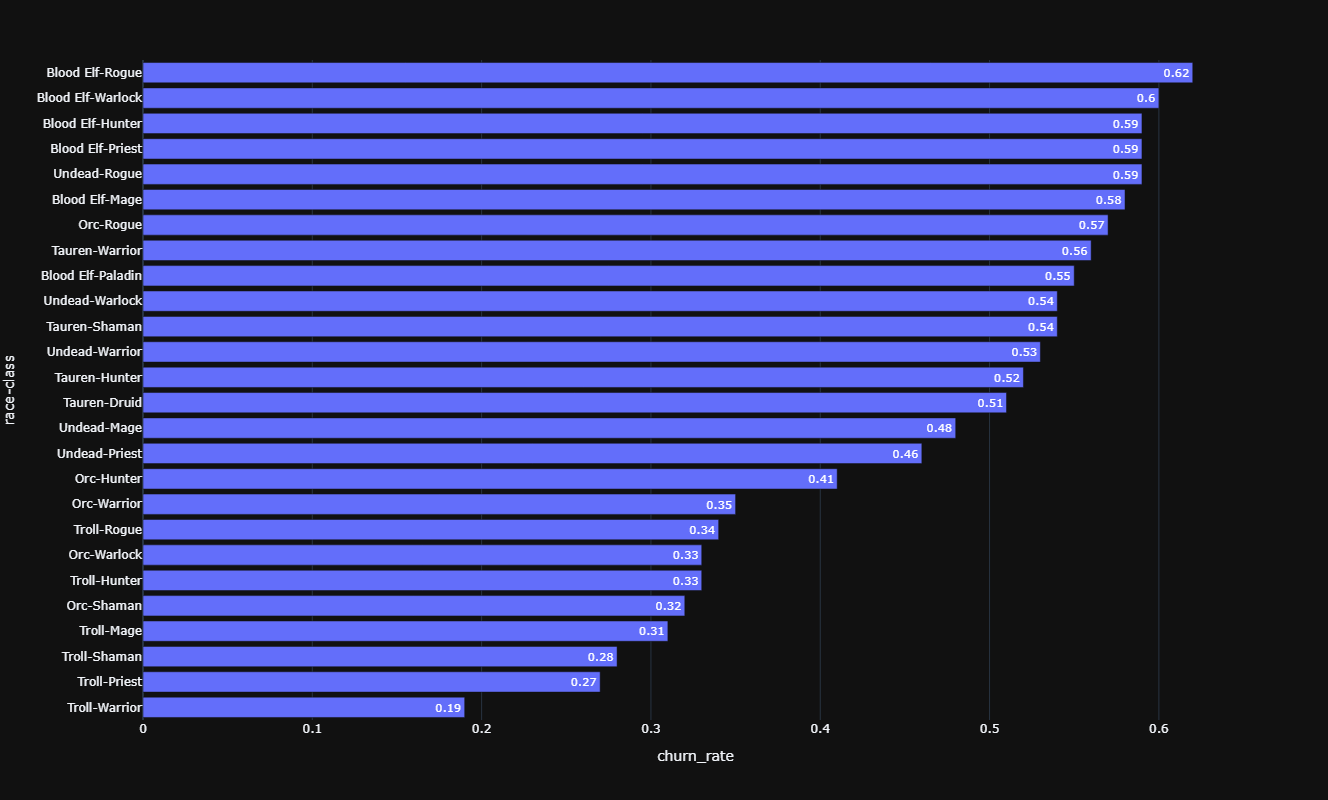

In [37]:
nusers_race_class = last_log.groupby(by=['race', 'charclass']).char.count().reset_index().rename(columns={'char':'total_users'})
cusers_race_class = churn_users.groupby(by=['race', 'charclass']).char.count().reset_index().rename(columns={'char':'churn_users'})

race_n_class = pd.merge(nusers_race_class, cusers_race_class, on=['race', 'charclass'])
race_n_class['churn_rate'] = race_n_class['churn_users'] / race_n_class['total_users']
race_n_class = race_n_class.sort_values(by='churn_rate', ascending=True)

race_n_class['race-class'] = race_n_class['race'] + '-' + race_n_class['charclass']
race_n_class['churn_rate'] = [round(x, 2) for x in race_n_class['churn_rate']]

fig = px.bar(race_n_class, x='churn_rate', y='race-class', text='churn_rate', width=800, height=800, template='plotly_dark')
fig.update_traces(textfont_size=12, textangle=0)
fig.show()

fig.write_image("img/race_class_churn.png")

In [ ]:
* 어둠땅부턴 종족이나 직업 퀘스트/추방자의 해안으로 10레벨까지 / 격전의 아제로스 지역에서 50레벨까지 / 어둠땅 지역에서 60레벨까지

In [38]:
zones = pd.read_csv('zones.csv')
locations = pd.read_csv('locations.csv')

In [39]:
# 지역별 최소 레벨
zone_level_min = zones[['Zone_Name', 'Min_req_level']].rename(columns={'Zone_Name':'zone'})

In [40]:
zone_churn_level = pd.merge(churn_zone, zone_level_min, on='zone')

<AxesSubplot:xlabel='Min_req_level', ylabel='char'>

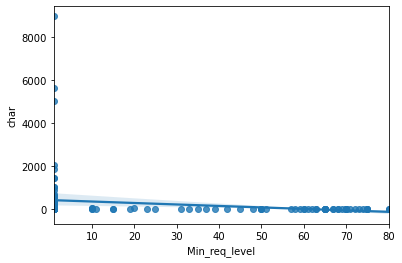

In [41]:
sns.regplot(x='Min_req_level', y='char', data=zone_churn_level)

* eversongwoods: 영원노래의 숲: 블러드 엘프 캐릭터로 플레이할 경우 여기에서 게임을 시작. 퀘스트 동선이 산들바람 마을을 중심으로 서부 성소, 원정순찰대 산장, 숲 남부 등 여기저기 돌아다니도록 짜여 있기 때문에 매우 피곤. 블러드 엘프 종족으로 시작하는 경우 이탈이 심한 이유가 이것 아닌지.
* 오그리마 : 정문에 서있던 사울팽,[2] 굴곡이 심한 지형, 구불구불한 길, 곳곳에 산재한 뒷골목 등 구조가 매우 복잡하다. 특히 수장인 스랄까지의 접근성이 최악
* 듀로타 : 눈 아프다. 필드 전체가 밝으면서 새빨갛기 때문에 불모의 땅의 황색에 눈이 익숙해져 있는 상태에서 진입하면 부담

In [61]:
df_zone = pd.merge(df, zone_level_min, how='left', on='zone')

In [62]:
df_zone.char.nunique()

37354

In [63]:
df_zone_user = df_zone.groupby('char').agg({'level':'max', 'Min_req_level':'max'}) #유저별 최종 레벨과 도달한 지역 중 가장 높은 레벨을 요구한 경우

In [88]:
def level_mapping(df):
    df['level10'] = df.Min_req_level.map(lambda x: '1-10' if x <= 10 else None)
    df['level20'] = df.Min_req_level.map(lambda x: '10-20' if x <= 20 and x > 10 else None)
    df['level30'] = df.Min_req_level.map(lambda x: '20-30' if x <= 30 and x > 20 else None)
    df['level40'] = df.Min_req_level.map(lambda x: '30-40' if x <= 40 and x > 30 else None)
    df['level50'] = df.Min_req_level.map(lambda x: '40-50' if x <= 50 and x > 40 else None)
    df['level60'] = df.Min_req_level.map(lambda x: '50-60' if x <= 60 and x > 50 else None)
    df['level70'] = df.Min_req_level.map(lambda x: '60-70' if x <= 70 and x > 60 else None)
    df['level80'] = df.Min_req_level.map(lambda x: '70-80' if x <= 80 and x > 70 else None)
    
    return df

In [ ]:
df_zone_user = level_mapping(df_zone_user)

In [65]:
df_zone_user_re = df_zone_user.fillna('')

In [66]:
df_zone_user_re['level_range'] = df_zone_user_re['level10'] + df_zone_user_re['level20'] + df_zone_user_re['level30'] + df_zone_user_re['level40'] \
                                + df_zone_user_re['level50'] + df_zone_user_re['level60'] + df_zone_user_re['level70'] + df_zone_user_re['level80']

In [67]:
df_zone_user_re = df_zone_user_re[['level', 'Min_req_level', 'level_range']]

In [68]:
level_funnel_df = df_zone_user_re.groupby('level_range').count().reset_index()[['level_range', 'Min_req_level']].rename(columns={'Min_req_level':'users'})

In [69]:
level_funnel_df = level_funnel_df.sort_values(by='level_range', ascending=False)

In [70]:
level_funnel_df['cumsum_users'] = level_funnel_df.users.cumsum()

In [71]:
level_funnel_df = level_funnel_df.sort_values(by='level_range', ascending=True)

In [72]:
#전체 유저 대비 단계별 전환율 계산
level_funnel_df.cumsum_users / level_funnel_df.cumsum_users[0]

0    1.000000
1    0.185040
2    0.167104
3    0.147267
4    0.131338
5    0.122584
6    0.107137
7    0.026530
Name: cumsum_users, dtype: float64

In [73]:
#이전 단계별 전환율 계산
for i in range(len(level_funnel_df)-1):
    level_funnel_df.loc[i+1, 'conversion'] = level_funnel_df.loc[i+1, 'cumsum_users'] / level_funnel_df.loc[i, 'cumsum_users']

In [74]:
level_funnel_df

level_range  users  cumsum_users  conversion
0        1-10  30442         37354         NaN
1       10-20    670          6912    0.185040
2       20-30    741          6242    0.903067
3       30-40    595          5501    0.881288
4       40-50    327          4906    0.891838
5       50-60    577          4579    0.933347
6       60-70   3011          4002    0.873990
7       70-80    991           991    0.247626

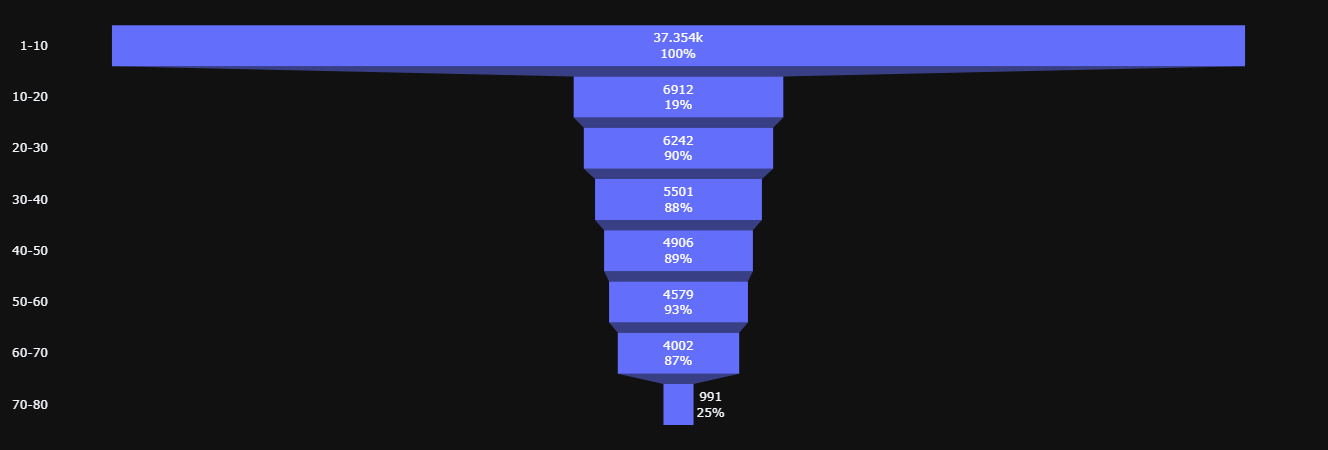

In [75]:
from plotly import graph_objects as go

fig = go.Figure()

fig.add_trace(go.Funnel(
    y = level_funnel_df['level_range'],
    x = level_funnel_df['cumsum_users'],
    textinfo = "value+percent previous"))


fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    width=800,
    height=450,
    template='plotly_dark'
)

fig.write_image("img/funnel_entire.png")
fig.show()

In [76]:
df_blk = df_zone[df_zone.datetime < '2008-11-13'].reset_index()

df_zone_user_blk = df_blk.groupby('char').agg({'level':'max', 'Min_req_level':'max'}) #유저별 최종 레벨과 도달한 지역 중 가장 높은 레벨을 요구한 경우

df_zone_user_blk = level_mapping(df_zone_user_blk)
df_zone_user_blk['level80'] = df_zone_user_blk.Min_req_level.map(lambda x: '70-80' if x <= 80 and x > 70 else None)

df_zone_user_blk_re = df_zone_user_blk.fillna('')

df_zone_user_blk_re['level_range'] = df_zone_user_blk_re['level10'] + df_zone_user_blk_re['level20'] + df_zone_user_blk_re['level30'] + df_zone_user_blk_re['level40'] \
                                + df_zone_user_blk_re['level50'] + df_zone_user_blk_re['level60'] + df_zone_user_blk_re['level70'] + df_zone_user_blk_re['level80']


df_zone_user_blk_re = df_zone_user_blk_re[['level', 'Min_req_level', 'level_range']]

funnel_df_blk = df_zone_user_blk_re.groupby('level_range').count().reset_index()[['level_range', 'Min_req_level']].rename(columns={'Min_req_level':'users'})
funnel_df_blk = funnel_df_blk.sort_values(by='level_range', ascending=False)
funnel_df_blk['cumsum_users'] = funnel_df_blk.users.cumsum()
funnel_df_blk = funnel_df_blk.sort_values(by='level_range', ascending=True)

#전체 유저 대비 단계별 전환율 계산
funnel_blk = pd.DataFrame(funnel_df_blk.cumsum_users / funnel_df_blk.cumsum_users[0]).reset_index()

#이전 단계별 전환율 계산
for i in range(len(funnel_df_blk)-1):
    funnel_df_blk.loc[i+1, 'conversion'] = funnel_df_blk.loc[i+1, 'cumsum_users'] / funnel_df_blk.loc[i, 'cumsum_users']

In [77]:
funnel_df_blk

level_range  users  cumsum_users  conversion
0        1-10  25955         32075         NaN
1       10-20    620          6120    0.190803
2       20-30    677          5500    0.898693
3       30-40    514          4823    0.876909
4       40-50    307          4309    0.893427
5       50-60    434          4002    0.928754
6       60-70   3568          3568    0.891554

* 리치왕의분노(리분) 런칭 후 퍼널 전환율 분석

In [78]:
df_lk = df_zone[df_zone.datetime >= '2008-11-13'].reset_index()

In [79]:
df_zone_user_lk = df_lk.groupby('char').agg({'level':'max', 'Min_req_level':'max'}) #유저별 최종 레벨과 도달한 지역 중 가장 높은 레벨을 요구한 경우

df_zone_user_lk = level_mapping(df_zone_user_lk)
df_zone_user_lk['level80'] = df_zone_user_lk.Min_req_level.map(lambda x: '70-80' if x <= 80 and x > 70 else None)

df_zone_user_lk_re = df_zone_user_lk.fillna('')

df_zone_user_lk_re['level_range'] = df_zone_user_lk_re['level10'] + df_zone_user_lk_re['level20'] + df_zone_user_lk_re['level30'] + df_zone_user_lk_re['level40'] \
                                + df_zone_user_lk_re['level50'] + df_zone_user_lk_re['level60'] + df_zone_user_lk_re['level70'] + df_zone_user_lk_re['level80']

In [80]:
df_zone_user_lk_re = df_zone_user_lk_re[['level', 'Min_req_level', 'level_range']]

In [81]:
funnel_df_lk = df_zone_user_lk_re.groupby('level_range').count().reset_index()[['level_range', 'Min_req_level']].rename(columns={'Min_req_level':'users'})
funnel_df_lk = funnel_df_lk.sort_values(by='level_range', ascending=False)
funnel_df_lk['cumsum_users'] = funnel_df_lk.users.cumsum()
funnel_df_lk = funnel_df_lk.sort_values(by='level_range', ascending=True)

In [82]:
#전체 유저 대비 단계별 전환율 계산
funnel_lk = pd.DataFrame(funnel_df_lk.cumsum_users / funnel_df_lk.cumsum_users[0]).reset_index()

In [83]:
#이전 단계별 전환율 계산
for i in range(len(funnel_df_lk)-1):
    funnel_df_lk.loc[i+1, 'conversion'] = funnel_df_lk.loc[i+1, 'cumsum_users'] / funnel_df_lk.loc[i, 'cumsum_users']

In [84]:
funnel_df_lk

level_range  users  cumsum_users  conversion
0        1-10   8754         11454         NaN
1       10-20    164          2700    0.235726
2       20-30    154          2536    0.939259
3       30-40    188          2382    0.939274
4       40-50     99          2194    0.921075
5       50-60    248          2095    0.954877
6       60-70    856          1847    0.881623
7       70-80    991           991    0.536546

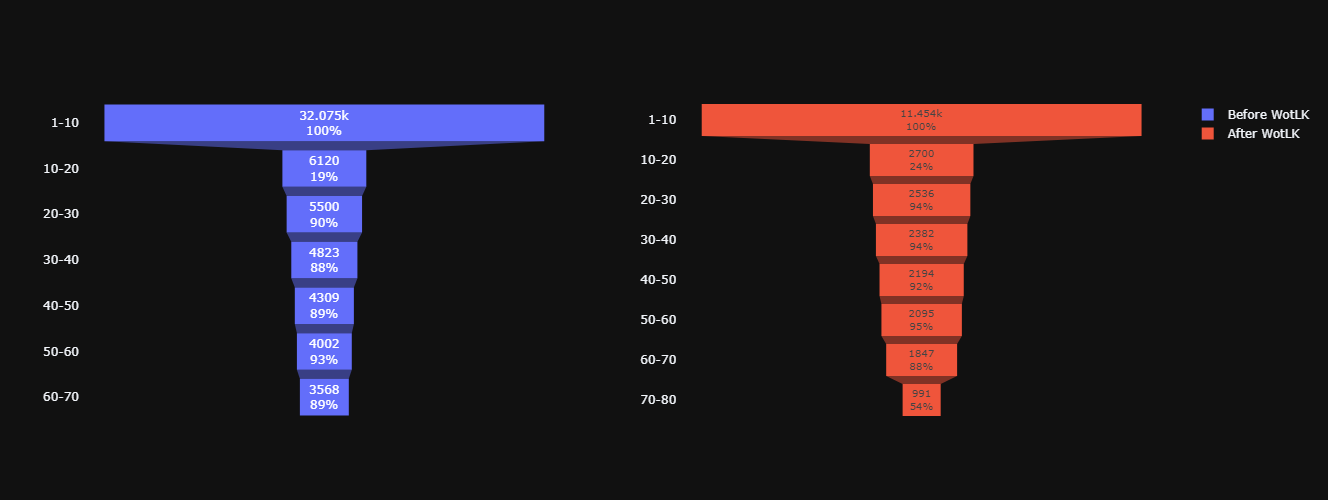

In [132]:
from plotly.subplots import make_subplots
from plotly import graph_objects as go

fig = make_subplots(rows=1, cols=2)


fig.add_trace(go.Funnel(
            name = 'Before WotLK',
            y = funnel_df_blk['level_range'],
            x = funnel_df_blk['cumsum_users'],
            textinfo = "value+percent previous"),
            row=1, col=1)


fig.add_trace(go.Funnel(
            name = 'After WotLK',
            y = funnel_df_lk['level_range'],
            x = funnel_df_lk['cumsum_users'],
            textposition = "inside",
            textinfo = "value+percent previous"),
              row=1, col=2)


fig.update_layout(width=1200, height=500, template='plotly_dark')
fig.write_image("img/funnel_lk_or_not.png")
fig.show()

* 리분 런칭 이후 모든 단계의 전환율이 상승했으며, 새로 개설된 70-80 레벨 구간까지 진입한 유저도 이전 단계 대비 50퍼센트 이상으로 확인됨.

In [ ]:
#이탈한 유저와 그렇지 않은 유저의 로그 분리

In [158]:
churn_users = last_log[last_log.churn==1].reset_index()

In [160]:
churn_chars = list(churn_users.char)

In [182]:
df_zone_user_churn = df_zone_user[df_zone_user.index.isin(churn_chars)] #이탈
df_zone_user_no_churn = df_zone_user[~df_zone_user.index.isin(churn_chars)] #이탈 안함

In [183]:
#이탈하지 않은 유저만 대상으로 퍼널 분석

In [184]:
nchurn_zone_re = df_zone_user_no_churn.fillna('')

In [185]:
def funnel_analysis(df):
    df['level_range'] = df['level10'] + df['level20'] + df['level30'] + df['level40'] \
                        + df['level50'] + df['level60'] + df['level70'] + df['level80']
    
    df = df[['level', 'Min_req_level', 'level_range']]
    
    funnel_df = df.groupby('level_range').count().reset_index()[['level_range', 'Min_req_level']].rename(columns={'Min_req_level':'users'})
    funnel_df = funnel_df.sort_values(by='level_range', ascending=False)
    funnel_df['cumsum_users'] = funnel_df.users.cumsum()
    funnel_df = funnel_df.sort_values(by='level_range', ascending=True)
    
    for i in range(len(funnel_df)-1):
        funnel_df.loc[i+1, 'conversion'] = funnel_df.loc[i+1, 'cumsum_users'] / churn_funnel_df.loc[i, 'cumsum_users']
        
    return funnel_df

In [186]:
nchurn_funnel_df = funnel_analysis(nchurn_zone_re)

In [187]:
nchurn_funnel_df

level_range  users  cumsum_users  conversion
0        1-10  15328         20516         NaN
1       10-20    338          5188    0.308113
2       20-30    475          4850    2.813225
3       30-40    392          4375    3.142960
4       40-50    248          3983    3.537300
5       50-60    434          3735    4.046587
6       60-70   2310          3301    3.911137
7       70-80    991           991    1.413695

In [188]:
#이탈한 유저만 대상으로 퍼널 분석

In [189]:
churn_zone_re = df_zone_user_churn.fillna('')

In [190]:
churn_funnel_df = funnel_analysis(churn_zone_re)

In [191]:
churn_funnel_df

level_range  users  cumsum_users  conversion
0        1-10  15114         16838         NaN
1       10-20    332          1724    0.102387
2       20-30    266          1392    0.807425
3       30-40    203          1126    0.808908
4       40-50     79           923    0.819716
5       50-60    143           844    0.914410
6       60-70    701           701    0.830569

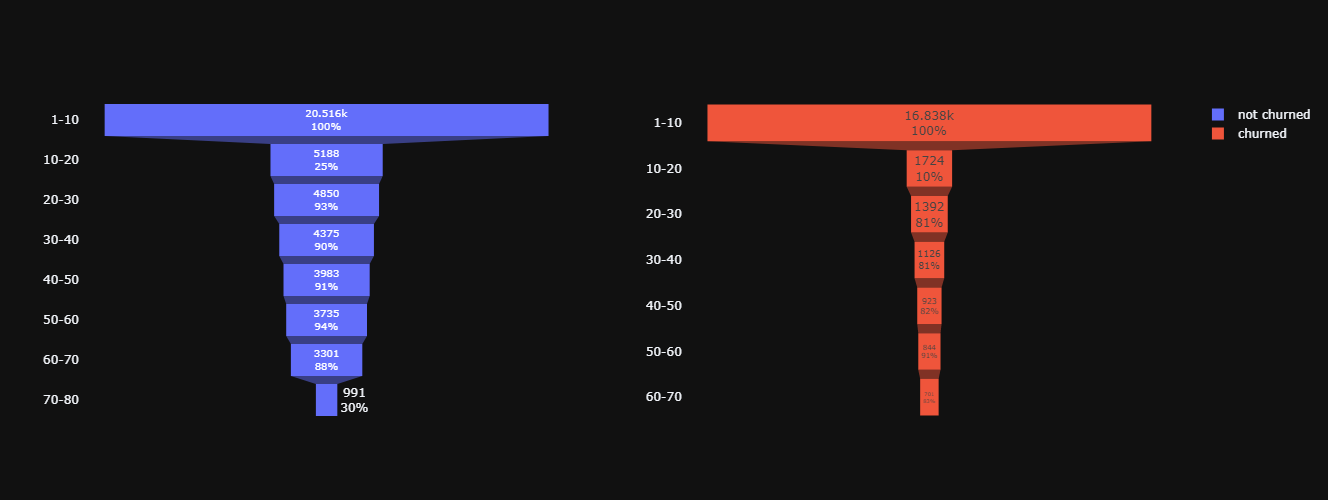

In [192]:
fig = make_subplots(rows=1, cols=2)


fig.add_trace(go.Funnel(
            name = 'not churned',
            y = nchurn_funnel_df['level_range'],
            x = nchurn_funnel_df['cumsum_users'],
            textinfo = "value+percent previous"),
            row=1, col=1)


fig.add_trace(go.Funnel(
            name = 'churned',
            y = churn_funnel_df['level_range'],
            x = churn_funnel_df['cumsum_users'],
            textposition = "inside",
            textinfo = "value+percent previous"),
              row=1, col=2)


fig.update_layout(width=1200, height=500, template='plotly_dark')
fig.write_image("img/funnel_churn_or_not.png")
fig.show()